PU comparison

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [5]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3'
datasets_loc = glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

Tmc20 = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    Tmc20.Add(floc)

print 'N evts: {:.0f}'.format(Tmc20.GetEntries())

N evts: 530076


In [6]:
dataDir = '../data/cmsMC_private/'
dataDir += 'BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3'
datasets_loc = glob(dataDir + '/ntuples_B2JpsiKst/out_CAND_*.root')

Tmc0 = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    Tmc0.Add(floc)

print 'N evts: {:.0f}'.format(Tmc0.GetEntries())

N evts: 759712


In [7]:
datasets_loc = glob('../data/cmsRD/ParkingBPH1/*2018C-*B2JpsiKst_200124_CAND.root')
TrdC = rt.TChain('outA/Tevts')
for floc in datasets_loc:
    TrdC.Add(floc)

print 'N evts: {:.0f}'.format(TrdC.GetEntries())

N evts: 2919923


# Plots

In [8]:
def plot(var, binning, cut_str='', axis_title=['', ''], leg_loc=[0.7, 0.7, 0.8, 0.9]):
    h1 = create_TH1D(np.zeros(0), name='h1', title='RD', axis_title=axis_title, binning=binning)
    TrdC.Project('h1', var, cut_str)

    h2 = create_TH1D(np.zeros(0), name='h2', title='MC 0', binning=binning)
    Tmc0.Project('h2', var, cut_str)
    
    h3 = create_TH1D(np.zeros(0), name='h3', title='MC 20', binning=binning)
    Tmc20.Project('h3', var, cut_str)
    
    leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[2], leg_loc[3])
    leg.SetBorderSize(0)
    h_list = [h1, h2, h3]
    colors = [rt.kBlack, rt.kRed, rt.kBlue]
    
    for i, h in enumerate(h_list):
        h.Sumw2()
        h.Scale(1./h.Integral())
        h.SetLineColor(colors[i])
        leg.AddEntry(h, h.GetTitle(), 'lep')

    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    c.SetRightMargin(0.15)
    c.dnd = [h_list, leg]
    leg.Draw()
    c.Draw()

    return c

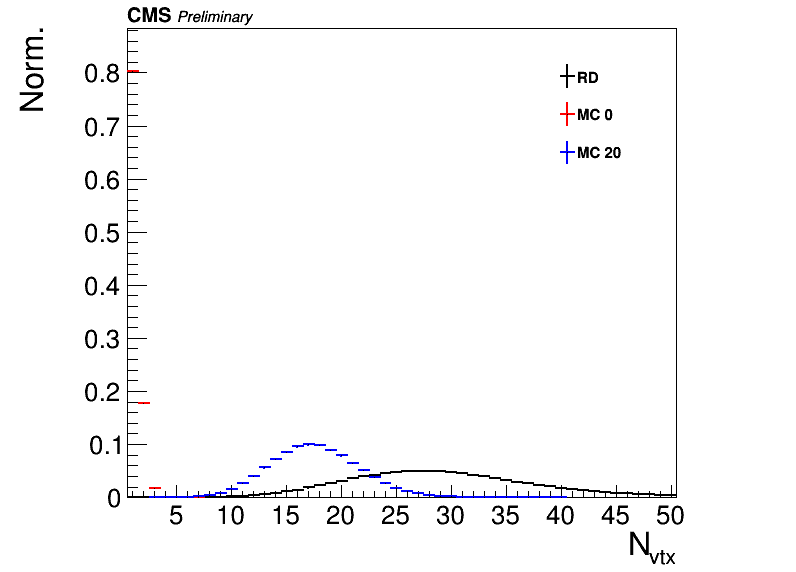

In [9]:
c = plot('N_vertexes', [50, 0.5, 50.5], '', axis_title=['N_{vtx}', 'Norm.'])

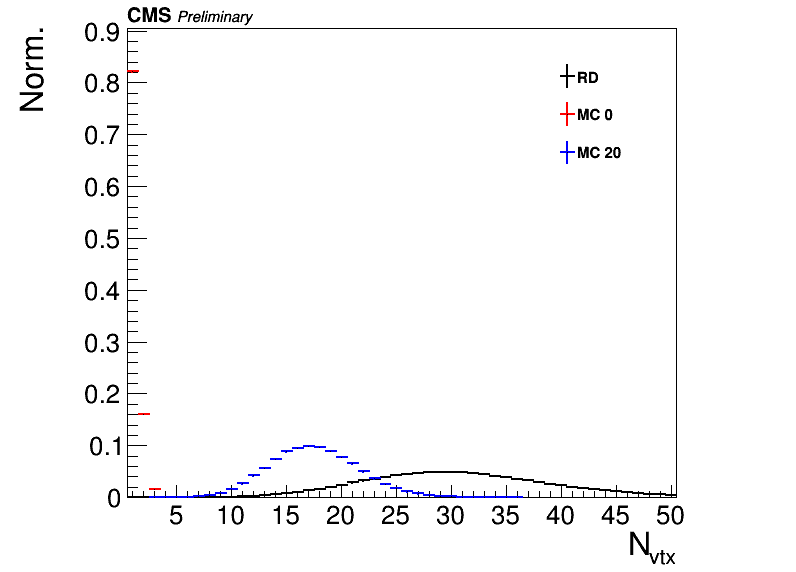

In [10]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu12_IP6)>0', axis_title=['N_{vtx}', 'Norm.'])

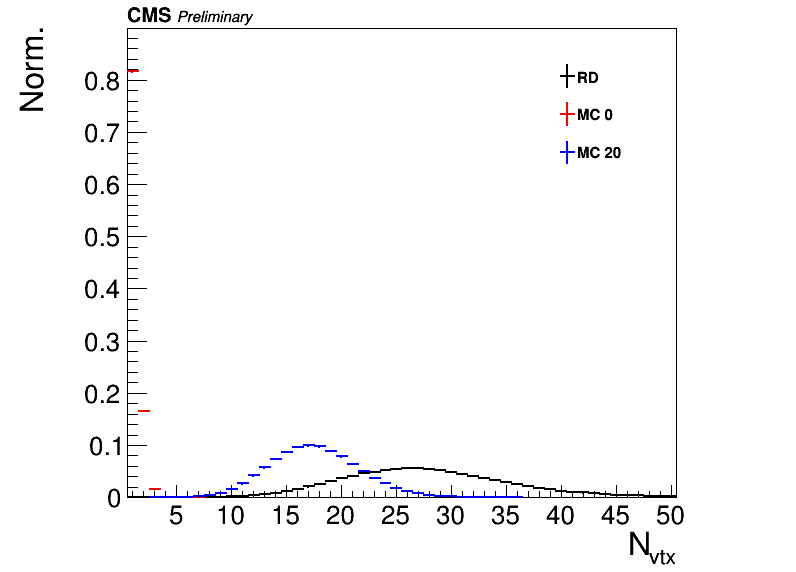

In [11]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu9_IP6)>0', axis_title=['N_{vtx}', 'Norm.'])

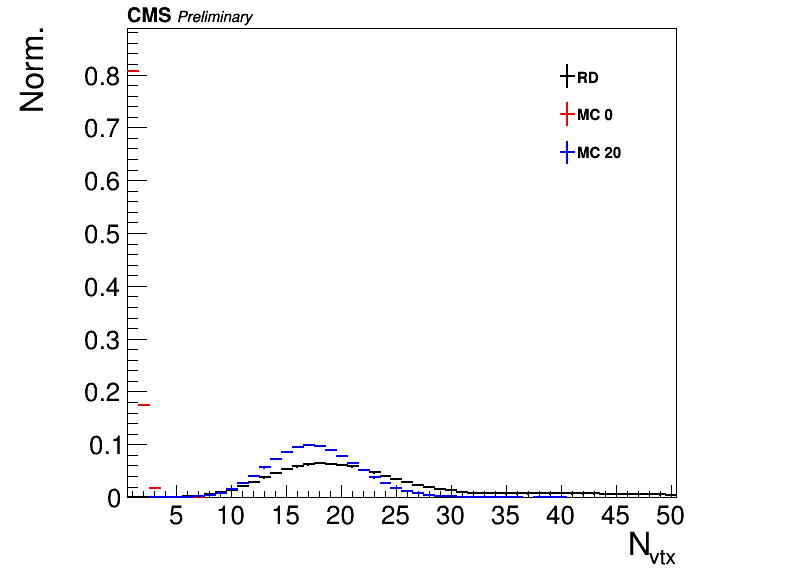

In [12]:
c = plot('N_vertexes', [50, 0.5, 50.5], 'Sum$(trgMu_HLT_Mu7_IP4)>0', axis_title=['N_{vtx}', 'Norm.'])

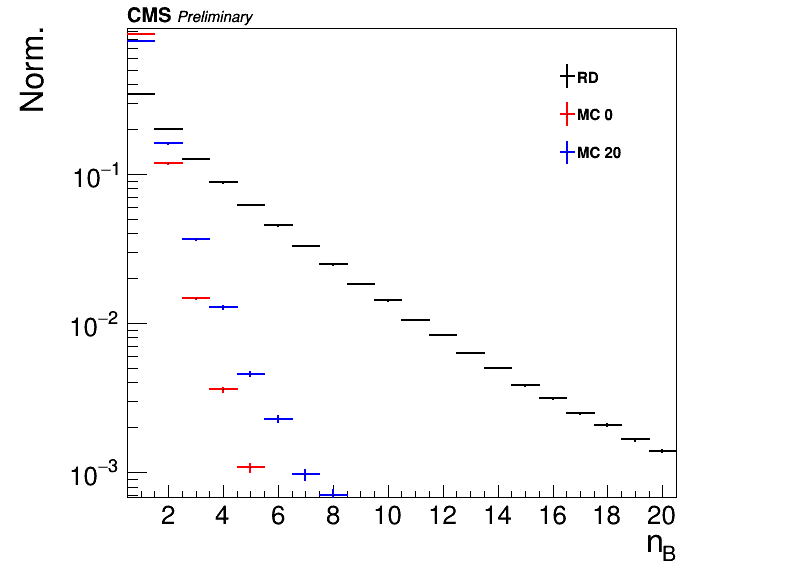

In [13]:
c = plot('n_B', [20, 0.5, 20.5], 'Sum$(trgMu_HLT_Mu12_IP6)>0', axis_title=['n_{B}', 'Norm.'])
c.SetLogy()

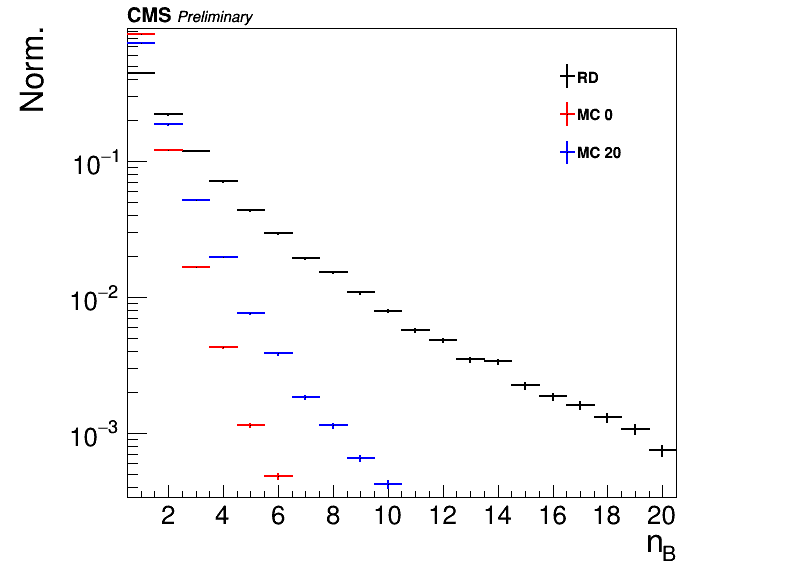

In [14]:
c = plot('n_B', [20, 0.5, 20.5], 'Sum$(trgMu_HLT_Mu7_IP4)>0', axis_title=['n_{B}', 'Norm.'])
c.SetLogy()

In [15]:
analysis_sel = ['n_B == 1',
                'mass_mumu < 3.176',
                'mass_mumu > 3.012',
                'mass_piK > 0.82',
                'mass_piK < 0.96',
                'mum_pt > 3.5',
                'mup_pt > 3.5',
                'Jpsi_pt > 6.9',
                'pval_mumu > 0.1',
                'mum_eta > -2.2',
                'mup_eta > -2.2',
                'mum_eta < 2.2',
                'mup_eta < 2.2',
                'cosT_Jpsi_PV > 0.95',
                'mum_dxy < 3',
                'mup_dxy < 3',
                'pval_piK > 0.1',
                'K_pt > 0.8',
                'mass_KK > 1.035', 
                'K_sigdxy_PV > 2',
                'pi_sigdxy_PV > 2', 
                'sigdxy_vtxKst_PV > 5',
                'fabs(mass_piK - 0.895) < fabs(mass_piK_CPconj - 0.895)', 
                'pval_mumupiK > 0.1', 'pi_pt > 0.8']

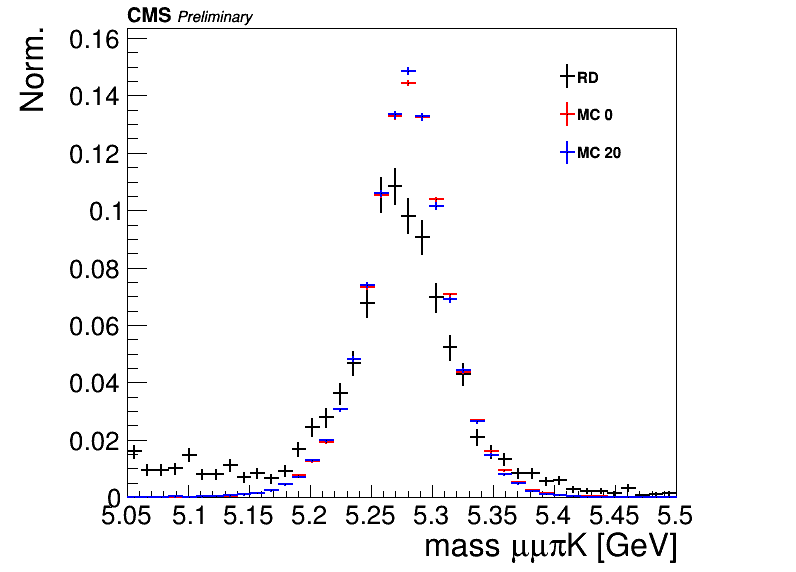

In [17]:
c = plot('mass_mumupiK', [40, 5.05, 5.5], ' && '.join(analysis_sel), axis_title=['mass #mu#mu#piK [GeV]', 'Norm.'])

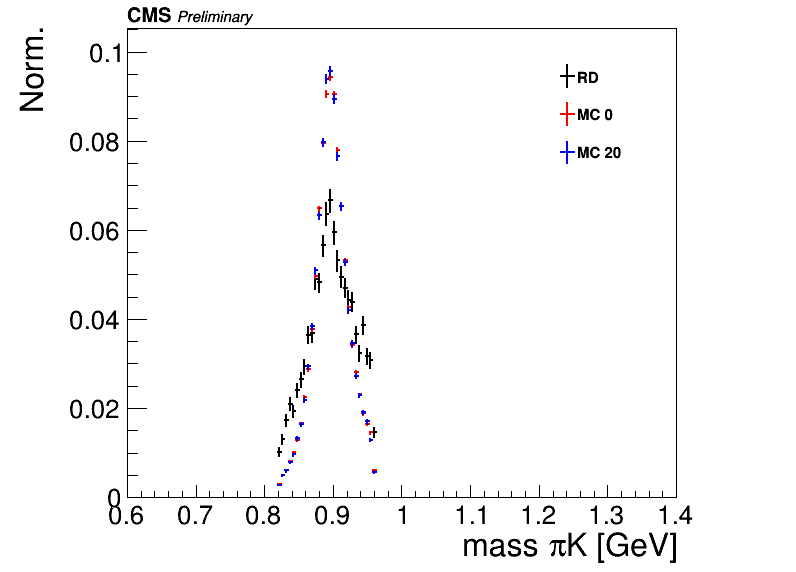

In [18]:
c = plot('mass_piK', [150, 0.6, 1.4], ' && '.join(analysis_sel), axis_title=['mass #piK [GeV]', 'Norm.'])